<a href="https://colab.research.google.com/github/yongbin02/AI/blob/main/10%EC%A3%BC%EC%B0%A8/UCI_HAR_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, LSTM,
    Conv1D, MaxPooling1D, concatenate
)

In [3]:
def load_file(filepath):
    # 하나의 txt 파일을 읽어서 넘파이 배열로 반환
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
def load_group(filenames, prefix=''):
    # 여러 센서 파일을 읽어 3D 텐서로 결합
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)     # shape: (samples, timesteps, channels)
    return loaded

In [5]:
def load_dataset_group(group, prefix=''):
    # 특정 그룹(train/test)의 inertial signals 데이터 9개 불러오기
    filepath = prefix + group + '/Inertial Signals/'

    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    # X: 9개 센서 로드
    X = load_group(filenames, filepath)

    # y: 활동 레이블
    y = load_file(prefix + group + '/y_'+group+'.txt')

    return X, y

In [6]:
def load_dataset(prefix=''):

    base = '/content/drive/MyDrive/Colab Notebooks/AI/20251104/data/UCI HAR Dataset/'     # UCI HAR 기본 폴더

    # load all train
    trainX, trainy = load_dataset_group('train', base)

    # load all test
    testX, testy = load_dataset_group('test', base)

    # zero-offset class values (1~6 → 0~5)
    trainy = trainy - 1
    testy = testy - 1

    # one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(trainX.shape, trainy.shape, trainy_one_hot.shape,
          testX.shape, testy.shape, testy_one_hot.shape)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [8]:
scaler = StandardScaler()

# reshape → scale → reshape back (3D 유지)
trainX_2d = trainX.reshape(-1, trainX.shape[2])
testX_2d = testX.reshape(-1, testX.shape[2])

trainX_scaled = scaler.fit_transform(trainX_2d).reshape(trainX.shape)
testX_scaled = scaler.transform(testX_2d).reshape(testX.shape)

# 스케일링된 데이터로 교체
trainX = trainX_scaled
testX = testX_scaled

In [9]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2, random_state=100
)

X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape, y_train.shape, y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [11]:
## 모델 입력 변수 설정
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [12]:
# CNN + LSTM 모델
inputs = Input(shape=(n_timesteps, n_features))

# -----------------------
# CNN FEATURE EXTRACTION
# -----------------------
conv1 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# -----------------------
# LSTM SEQUENCE MODELING
# -----------------------
lstm_layer = LSTM(64, return_sequences=False)(pool2)
lstm_layer = Dropout(0.3)(lstm_layer)

# -----------------------
# DENSE CLASSIFICATION
# -----------------------
dense = Dense(512, activation='relu')(lstm_layer)
dense = Dropout(0.5)(dense)

outputs = Dense(n_outputs, activation='softmax')(dense)

# Build model
cnn_lstm_model = Model(inputs, outputs)

cnn_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,606 (381.27 KB)

 Trainable params: 97,606 (381.27 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = cnn_lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6354 - loss: 0.8890 - val_accuracy: 0.9202 - val_loss: 0.1875
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9074 - loss: 0.2498 - val_accuracy: 0.9440 - val_loss: 0.1131
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9412 - loss: 0.1546 - val_accuracy: 0.9440 - val_loss: 0.0999
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9462 - loss: 0.1270 - val_accuracy: 0.9338 - val_loss: 0.1223
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9452 - loss: 0.1349 - val_accuracy: 0.9508 - val_loss: 0.0998
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9500 - loss: 0.1211 - val_accuracy: 0.9491 - val_loss: 0.1036
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9583 - loss: 0.0937 - val_accuracy: 0.9491 - val_loss: 0.0926
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9536 - loss: 0.1017 - val_accu

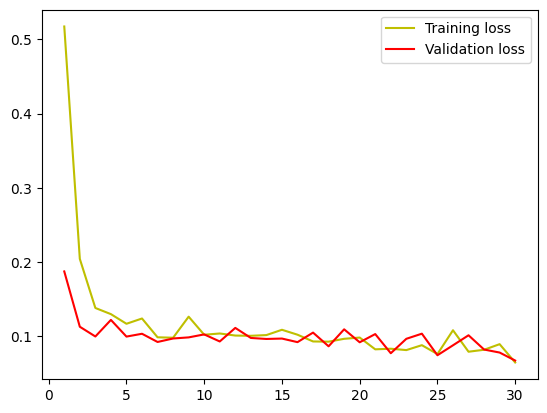

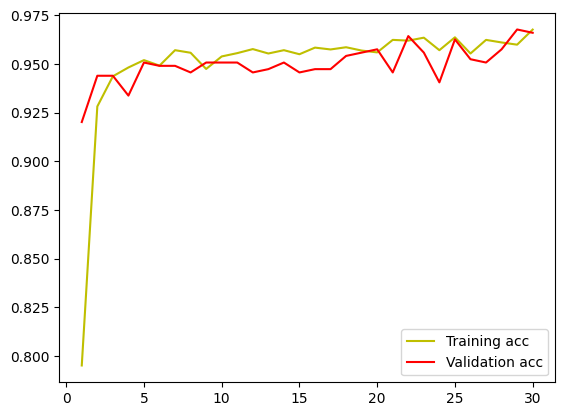

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[481   0  15   0   0   0]
 [  3 443  25   0   0   0]
 [  0   0 420   0   0   0]
 [  0   8   0 402  81   0]
 [  1   1   0 109 421   0]
 [  0   0   0   0   0 537]]
0.9175432643366135
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.98      0.94      0.96       471
           2       0.91      1.00      0.95       420
           3       0.79      0.82      0.80       491
           4       0.84      0.79      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

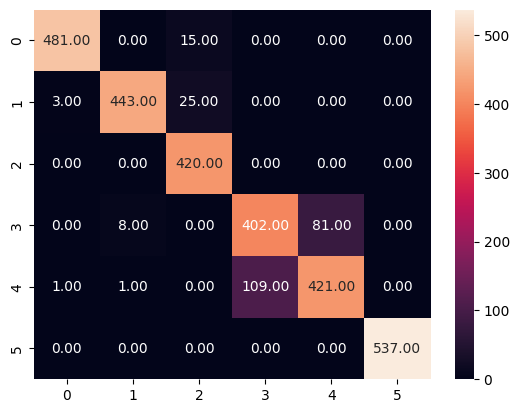

In [15]:
pred = cnn_lstm_model.predict(testX)

pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')